In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt

from datetime import date, timedelta
import timeit, functools

from tqdm.auto import tqdm

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

In [13]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*5
end_date = current_date + timedelta(days=forecast_length)

np_offline_data = np_sim.get_offline_data(token, start_date, current_date, end_date)
jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-06-01 2023-06-22 2028-06-20


In [4]:
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
lock_target = 0.3
sector_duration=360

In [10]:
num_mc = 100
forecast_length_yrs_vec = range(1,20)

In [17]:
# Time Numpy
np_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length = forecast_length_yrs*365
    
    end_date = current_date + timedelta(days=forecast_length)
    np_offline_data = np_sim.get_offline_data(token, start_date, current_date, end_date)

    t = timeit.Timer(
        functools.partial(np_sim.run_simple_sim_offline, 
                          start_date,
                          current_date,
                          forecast_length,
                          rr_val,
                          rbp_val,
                          fpr_val,
                          sector_duration,
                          np_offline_data
                         ),
    )
    np_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
# Time JAX
jax_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length = forecast_length_yrs*365

    rbp = jnp.ones(forecast_length) * rbp_val
    rr = jnp.ones(forecast_length) * rr_val
    fpr = jnp.ones(forecast_length) * fpr_val

    end_date = current_date + timedelta(days=forecast_length)
    jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

    
    t = timeit.Timer(
        functools.partial(sim.run_sim, 
                          rbp,
                          rr,
                          fpr,
                          lock_target,
                          start_date,
                          current_date,
                          forecast_length,
                          sector_duration,
                          offline_data
                         ),
    )
    jax_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/19 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


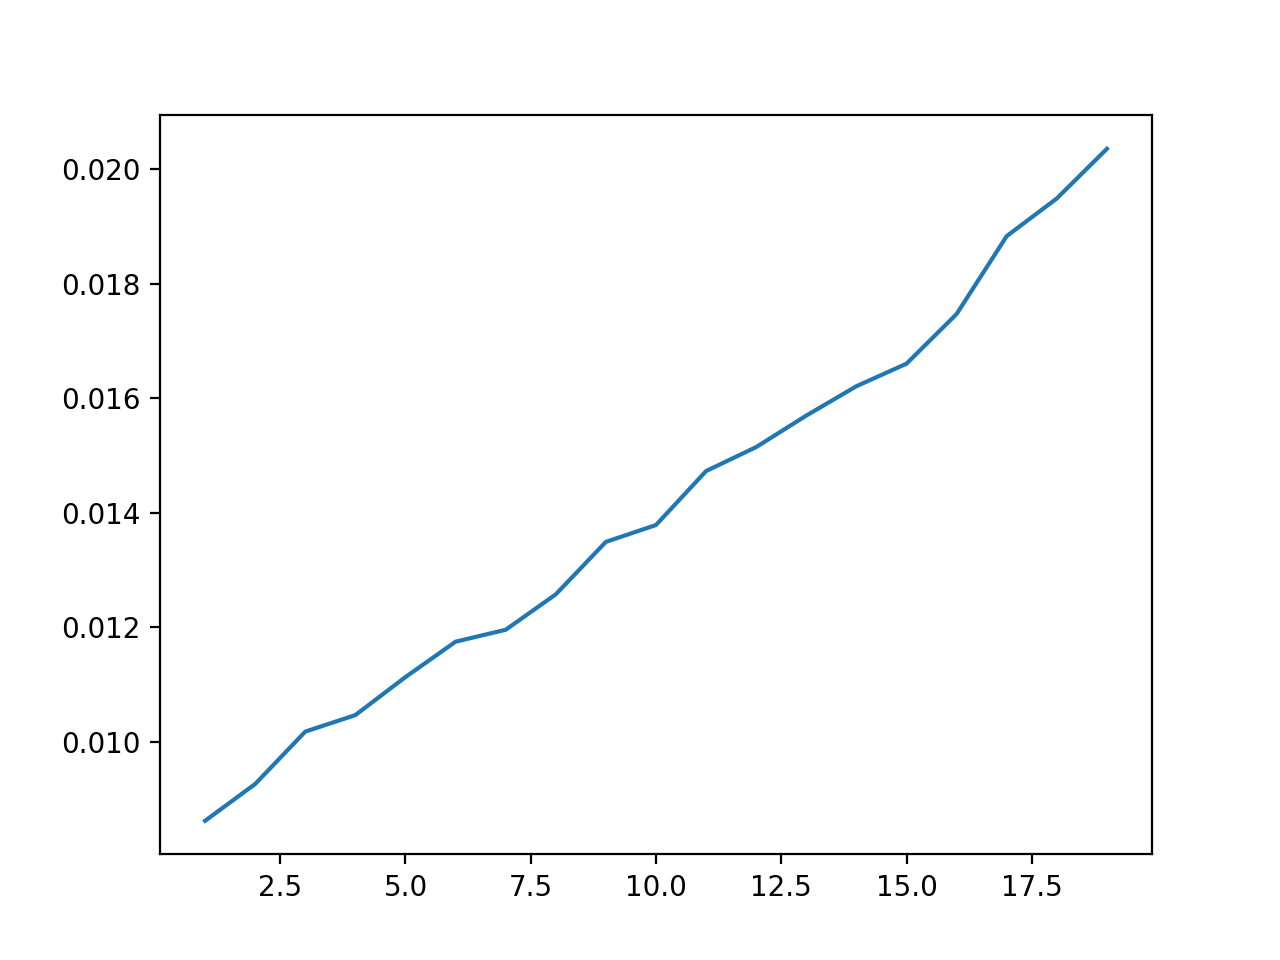

In [12]:
plt.figure()
plt.plot(forecast_length_yrs_vec, jax_speeds)